In [212]:

import matplotlib.pyplot as plt
from itertools import permutations, combinations
from random import shuffle
import random
import numpy as np
import statistics
import pandas as pd
import seaborn as SNs
import imageio

no eliminar ------ lectura de datos

In [21]:
def load_tsp_data(file_path):
    coords = []
    section = False

    with open(file_path, 'r') as f:
        for line in f:
            line = line.strip()

            if line.startswith("NODE_COORD_SECTION"):
                section = True
                continue

            if line == "EOF":
                break

            if section:
                parts = line.split()
                if len(parts) >= 3:
                    try:
                        x, y = float(parts[1]), float(parts[2])
                        coords.append((x, y))
                    except ValueError:
                        print(f"Error al convertir: {parts}")

    return coords

In [22]:
coords = load_tsp_data('ch150.tsp')
coords

[(37.4393516691, 541.2090699418),
 (612.1759508571, 494.3166877396),
 (38.1312338227, 353.1484581781),
 (53.4418081065, 131.484901365),
 (143.0606355347, 631.7200953923),
 (689.9451267256, 468.5354998742),
 (112.7478815786, 529.417757826),
 (141.4875865042, 504.818485571),
 (661.0513901702, 445.9375182115),
 (98.7899036592, 384.5926031158),
 (697.3881696597, 180.3962284275),
 (536.4894189738, 287.2279085051),
 (192.4067320507, 20.439405931),
 (282.7865258765, 229.8001556189),
 (240.8251726391, 281.51414372),
 (246.9281323057, 322.461332116),
 (649.7313216456, 62.3331575282),
 (352.96585626, 666.7873101942),
 (633.392367658, 534.9398453712),
 (488.311799404, 437.4869439948),
 (141.4039286509, 228.4325551488),
 (17.3632612602, 240.2407068508),
 (397.5586451389, 231.3591208928),
 (565.7853781464, 282.3858748974),
 (475.8975387047, 468.5392706317),
 (322.4224566559, 550.3165478233),
 (397.5586634023, 74.7588387765),
 (672.8618339396, 432.882640963),
 (571.2189680147, 530.261699153),
 (104.

In [23]:
len(coords)

150

In [24]:
city_coords = {str(i+1): coord for i, coord in enumerate(coords)}
city_coords

{'1': (37.4393516691, 541.2090699418),
 '2': (612.1759508571, 494.3166877396),
 '3': (38.1312338227, 353.1484581781),
 '4': (53.4418081065, 131.484901365),
 '5': (143.0606355347, 631.7200953923),
 '6': (689.9451267256, 468.5354998742),
 '7': (112.7478815786, 529.417757826),
 '8': (141.4875865042, 504.818485571),
 '9': (661.0513901702, 445.9375182115),
 '10': (98.7899036592, 384.5926031158),
 '11': (697.3881696597, 180.3962284275),
 '12': (536.4894189738, 287.2279085051),
 '13': (192.4067320507, 20.439405931),
 '14': (282.7865258765, 229.8001556189),
 '15': (240.8251726391, 281.51414372),
 '16': (246.9281323057, 322.461332116),
 '17': (649.7313216456, 62.3331575282),
 '18': (352.96585626, 666.7873101942),
 '19': (633.392367658, 534.9398453712),
 '20': (488.311799404, 437.4869439948),
 '21': (141.4039286509, 228.4325551488),
 '22': (17.3632612602, 240.2407068508),
 '23': (397.5586451389, 231.3591208928),
 '24': (565.7853781464, 282.3858748974),
 '25': (475.8975387047, 468.5392706317),
 '

---------------------------------------------------------------------------------- termina lectura de datos

In [56]:
def initial_population(cities_list, n_population=200):
    population = []
    for _ in range(n_population):
        individual = cities_list[:]  # Copia de la lista de ciudades
        random.shuffle(individual)  # Mezclar aleatoriamente
        population.append(individual)
    return population


In [57]:
n_cities = len(city_coords)
distance_matrix = np.zeros((n_cities, n_cities))

for i, (x1, y1) in enumerate(city_coords.values()):
    for j, (x2, y2) in enumerate(city_coords.values()):
        distance_matrix[i, j] = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

def dist_two_cities(city_1, city_2):
    index_1 = int(city_1) - 1  # Convertir de string a índice
    index_2 = int(city_2) - 1
    return distance_matrix[index_1, index_2]

In [58]:
def total_dist_individual(individual):
    total_dist = 0
    for i in range(0, len(individual)):
        if(i == len(individual) - 1):
            total_dist += dist_two_cities(individual[i], individual[0])
        else:
            total_dist += dist_two_cities(individual[i], individual[i+1])
    return total_dist

In [95]:
def fitness_prob(population):
    total_dist_all_individuals = np.array([total_dist_individual(ind) for ind in population])

    max_population_cost = np.max(total_dist_all_individuals)
    population_fitness = max_population_cost - total_dist_all_individuals

    population_fitness_sum = np.sum(population_fitness)

    # Si la suma es cero, asigna probabilidades iguales a todos los individuos
    if population_fitness_sum == 0:
        return np.ones(len(population)) / len(population)

    return population_fitness / population_fitness_sum

In [221]:
def roulette_wheel(population, fitness_probs):
    population_fitness_probs_cumsum = fitness_probs.cumsum()
    bool_prob_array = population_fitness_probs_cumsum < np.random.uniform(0,1,1)
    selected_individual_index = len(bool_prob_array[bool_prob_array == True]) - 1
    return population[selected_individual_index]

In [65]:
def crossover(parent_1, parent_2):
    n_cities_cut = len(city_coords) - 1
    cut = round(random.uniform(1, n_cities_cut))
    offspring_1 = []
    offspring_2 = []

    offspring_1 = parent_1 [0:cut]
    offspring_1 += [city for city in parent_2 if city not in offspring_1]


    offspring_2 = parent_2 [0:cut]
    offspring_2 += [city for city in parent_1 if city not in offspring_2]


    return offspring_1, offspring_2

In [62]:
def mutation(offspring):
    n_cities_cut = len(city_coords) - 1
    index_1 = round(random.uniform(0,n_cities_cut))
    index_2 = round(random.uniform(0,n_cities_cut))

    temp = offspring [index_1]
    offspring[index_1] = offspring[index_2]
    offspring[index_2] = temp
    return(offspring)

In [96]:
def run_ga(cities_names, n_population, n_generations,
           crossover_per, mutation_per):

    population = initial_population(cities_names, n_population)
    fitness_probs = fitness_prob(population)

    parents_list = []
    for i in range(0, int(crossover_per * n_population)):
        parents_list.append(roulette_wheel(population,
                                           fitness_probs))

    offspring_list = []
    for i in range(0,len(parents_list), 2):
        offspring_1, offspring_2 = crossover(parents_list[i],
                                             parents_list[i+1])

        mutate_threashold = random.random()
        if(mutate_threashold > (1-mutation_per)):
            offspring_1 = mutation(offspring_1)

        mutate_threashold = random.random()
        if(mutate_threashold > (1-mutation_per)):
            offspring_2 = mutation(offspring_2)


        offspring_list.append(offspring_1)
        offspring_list.append(offspring_2)

    mixed_offspring = parents_list + offspring_list

    fitness_probs = fitness_prob(mixed_offspring)
    sorted_fitness_indices = np.argsort(fitness_probs)[::-1]
    best_fitness_indices = sorted_fitness_indices[0:n_population]
    best_mixed_offsrping = []
    for i in best_fitness_indices:
        best_mixed_offsrping.append(mixed_offspring[i])

    while len(best_mixed_offsrping) < n_population:
      best_mixed_offsrping.append(random.choice(population))


    for i in range(0, n_generations):

        fitness_probs = fitness_prob(best_mixed_offsrping)
        parents_list = []
        for i in range(0, int(crossover_per * n_population)):
            parents_list.append(roulette_wheel(best_mixed_offsrping,
                                               fitness_probs))

        offspring_list = []
        for i in range(0,len(parents_list), 2):
            offspring_1, offspring_2 = crossover(parents_list[i],
                                                 parents_list[i+1])

            mutate_threashold = random.random()
            if(mutate_threashold > (1-mutation_per)):
                offspring_1 = mutation(offspring_1)

            mutate_threashold = random.random()
            if(mutate_threashold > (1-mutation_per)):
                offspring_2 = mutation(offspring_2)

            offspring_list.append(offspring_1)
            offspring_list.append(offspring_2)


        mixed_offspring = parents_list + offspring_list
        fitness_probs = fitness_prob(mixed_offspring)
        sorted_fitness_indices = np.argsort(fitness_probs)[::-1]
        best_fitness_indices = sorted_fitness_indices[0:int(0.8*n_population)]

        best_mixed_offsrping = []
        for i in best_fitness_indices:
            best_mixed_offsrping.append(mixed_offspring[i])

        old_population_indices = [random.randint(0, (n_population - 1))
                                  for j in range(int(0.2*n_population))]
        for i in old_population_indices:
            best_mixed_offsrping.append(population[i])

        random.shuffle(best_mixed_offsrping)

    return best_mixed_offsrping

In [67]:
cities_names = []
for i in range(len(city_coords)):
    cities_names.append(str(i+1))

cities_names

['1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '50',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '58',
 '59',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '68',
 '69',
 '70',
 '71',
 '72',
 '73',
 '74',
 '75',
 '76',
 '77',
 '78',
 '79',
 '80',
 '81',
 '82',
 '83',
 '84',
 '85',
 '86',
 '87',
 '88',
 '89',
 '90',
 '91',
 '92',
 '93',
 '94',
 '95',
 '96',
 '97',
 '98',
 '99',
 '100',
 '101',
 '102',
 '103',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '110',
 '111',
 '112',
 '113',
 '114',
 '115',
 '116',
 '117',
 '118',
 '119',
 '120',
 '121',
 '122',
 '123',
 '124',
 '125',
 '126',
 '127',
 '128',
 '129',
 '130',
 '131',
 '132',
 '133',
 '134',
 '135',
 '136',
 '137',
 '138',
 '13

In [215]:
n_population = 1000
crossover_per = 0.8
mutation_per = 0.2
n_generations = 3000

In [222]:
best_mixed_offsrping = run_ga(cities_names, n_population, n_generations, crossover_per, mutation_per)


IndexError: list index out of range

In [185]:
print(f"Tamaño de best_mixed_offsrping: {len(best_mixed_offsrping)}")
print(f"Tamaño esperado: {n_population}")

Tamaño de best_mixed_offsrping: 1000
Tamaño esperado: 1000


In [186]:
total_dist_all_individuals = []
for i in range(0, n_population):
    total_dist_all_individuals.append(total_dist_individual(best_mixed_offsrping[i]))


In [187]:
index_minimum = np.argmin(total_dist_all_individuals)
minimum_distance = min(total_dist_all_individuals)

shortest_path = best_mixed_offsrping[index_minimum]

In [188]:
print(f"El camino más corto es: {shortest_path}")
print(f"La distancia mínima es: {minimum_distance}")

El camino más corto es: ['53', '77', '122', '14', '131', '32', '38', '67', '12', '24', '69', '36', '61', '11', '148', '39', '41', '101', '116', '134', '105', '111', '79', '121', '94', '88', '104', '119', '91', '71', '44', '15', '133', '48', '34', '1', '103', '107', '5', '100', '143', '75', '132', '137', '102', '135', '86', '81', '110', '120', '9', '28', '6', '25', '141', '56', '146', '126', '33', '52', '16', '59', '78', '80', '72', '49', '147', '144', '43', '20', '109', '138', '90', '83', '26', '18', '142', '85', '65', '139', '130', '60', '17', '66', '117', '123', '74', '136', '64', '21', '10', '30', '84', '8', '89', '96', '113', '125', '22', '149', '62', '3', '73', '76', '87', '98', '82', '95', '97', '124', '7', '63', '35', '93', '55', '58', '50', '70', '108', '19', '2', '47', '51', '92', '54', '46', '29', '114', '99', '37', '42', '23', '129', '27', '31', '145', '13', '106', '68', '128', '45', '4', '150', '115', '112', '140', '57', '127', '118', '40']
La distancia mínima es: 12176.179

In [189]:
x_shortest = []
y_shortest = []

for city in shortest_path:
    x_value, y_value = city_coords[city]  # Usamos el diccionario `city_coords`
    x_shortest.append(x_value)
    y_shortest.append(y_value)

x_shortest.append(x_shortest[0])
y_shortest.append(y_shortest[0])

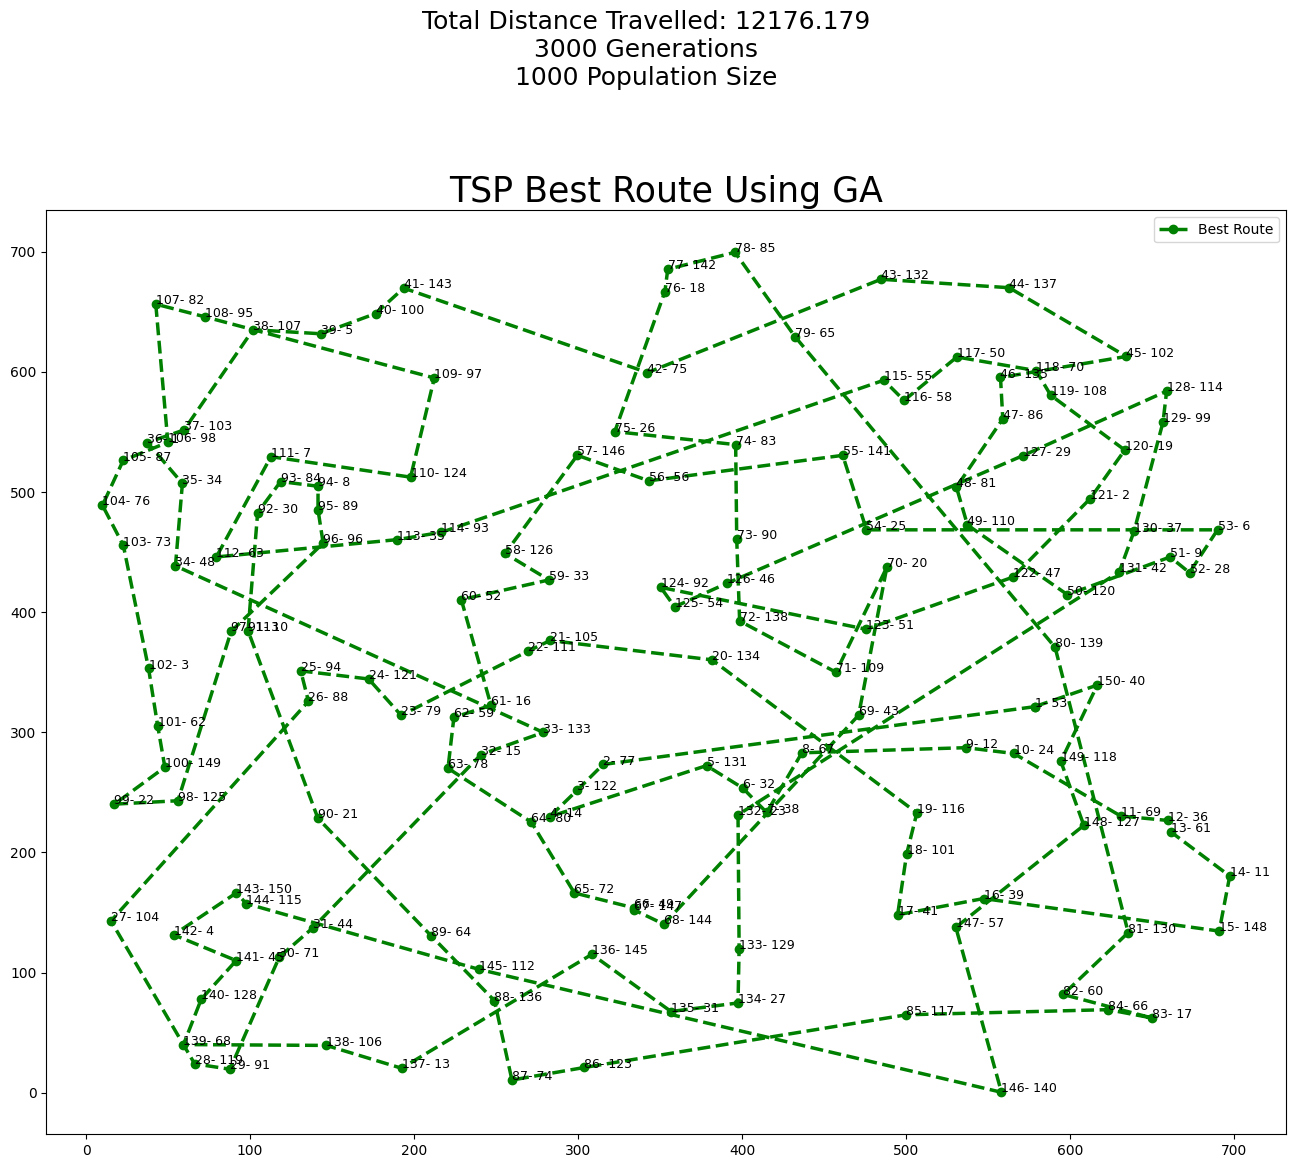

In [190]:
fig, ax = plt.subplots()

# Dibujar el camino más corto con líneas verdes y círculos en las ciudades
ax.plot(x_shortest, y_shortest, '--go', label='Best Route', linewidth=2.5)
plt.legend()

# 3. Dibujar conexiones adicionales entre todas las ciudades (opcional)

plt.title(label="TSP Best Route Using GA", fontsize=25, color="k")

str_params = (
    f'\n{n_generations} Generations\n{n_population} Population Size\n'
)

plt.suptitle(
    "Total Distance Travelled: " + str(round(minimum_distance, 3)) + str_params,
    fontsize=18, y=1.047
)

for i, city in enumerate(shortest_path):
    ax.annotate(f"{i+1}- {city}", (x_shortest[i], y_shortest[i]), fontsize=9)

fig.set_size_inches(16, 12)
plt.show()

In [228]:

def evolve_population(population, elite_fraction, crossover_per, mutation_per):

    elite_size = int(len(population) * elite_fraction)
    elite_individuals = sorted(population, key=total_dist_individual)[:elite_size]
    new_population = elite_individuals[:]

    print(f"Elite size: {elite_size}, Total population: {len(population)}")

    while len(new_population) < len(population):
        fitness_probs = fitness_prob(population)

        parent_1 = roulette_wheel(population, fitness_probs)
        parent_2 = roulette_wheel(population, fitness_probs)

        offspring_1, offspring_2 = crossover(parent_1, parent_2)

        if random.random() < mutation_per:
            offspring_1 = mutation(offspring_1)
        if random.random() < mutation_per:
            offspring_2 = mutation(offspring_2)

        new_population.extend([offspring_1, offspring_2])

    return new_population[:len(population)]


In [229]:
def run_ga_timeline(cities_list, n_population, n_generations, crossover_per, mutation_per, elite_fraction):
    population = initial_population(cities_list, n_population)

    best_routes = []  # Guardar rutas intermedias
    best_distances = []  # Guardar las distancias intermedias

    for generation in range(n_generations):
        fitness_probs = fitness_prob(population)
        best_individual = population[np.argmax(fitness_probs)]
        best_distance = total_dist_individual(best_individual)

        if generation % 150 == 0 or generation == n_generations - 1:
            best_routes.append(best_individual)
            best_distances.append(best_distance)

        # Evolucionar la población con `elite_fraction`
        population = evolve_population(population, elite_fraction, crossover_per, mutation_per)

    return best_routes, best_distances


In [230]:
import os
import matplotlib.pyplot as plt

In [231]:
os.makedirs('tsp_frames', exist_ok=True)

def plot_route(route, generation, distance, folder='tsp_frames'):
    """Genera una imagen de la ruta y la guarda en la carpeta especificada."""
    x = [city_coords[city][0] for city in route]
    y = [city_coords[city][1] for city in route]

    # Cerrar el ciclo de la ruta
    x.append(x[0])
    y.append(y[0])

    fig, ax = plt.subplots()
    ax.plot(x, y, '--ro', label=f'Generation {generation}', linewidth=2.5)
    plt.legend()

    plt.title(f"TSP Route - Generation {generation}\nDistance: {round(distance, 2)}", fontsize=18)
    fig.set_size_inches(10, 8)

    # Guardar la imagen
    plt.savefig(f'{folder}/generation_{generation}.png')
    plt.close()

In [ ]:
best_routes, best_distances = run_ga_timeline(
    list(city_coords.keys()), n_population, n_generations, crossover_per, mutation_per, elite_fraction=0.1
)



Elite size: 100, Total population: 1000
Elite size: 100, Total population: 1000
Elite size: 100, Total population: 1000
Elite size: 100, Total population: 1000
Elite size: 100, Total population: 1000
Elite size: 100, Total population: 1000
Elite size: 100, Total population: 1000
Elite size: 100, Total population: 1000
Elite size: 100, Total population: 1000
Elite size: 100, Total population: 1000
Elite size: 100, Total population: 1000
Elite size: 100, Total population: 1000
Elite size: 100, Total population: 1000
Elite size: 100, Total population: 1000
Elite size: 100, Total population: 1000
Elite size: 100, Total population: 1000
Elite size: 100, Total population: 1000
Elite size: 100, Total population: 1000
Elite size: 100, Total population: 1000
Elite size: 100, Total population: 1000
Elite size: 100, Total population: 1000
Elite size: 100, Total population: 1000
Elite size: 100, Total population: 1000
Elite size: 100, Total population: 1000
Elite size: 100, Total population: 1000


In [ ]:
for i, (route, distance) in enumerate(zip(best_routes, best_distances)):
    generation = i * 10  # Cada 50 generaciones
    plot_route(route, generation, distance)

In [ ]:
import imageio

def create_gif(output_path='tsp_evolution.gif', folder='tsp_frames'):
    """Crea un GIF a partir de las imágenes guardadas en la carpeta especificada."""
    images = []
    filenames = sorted(os.listdir(folder), key=lambda x: int(x.split('_')[1].split('.')[0]))

    for filename in filenames:
        img_path = os.path.join(folder, filename)
        images.append(imageio.imread(img_path))

    # Crear el GIF
    imageio.mimsave(output_path, images, fps=2)  # 2 frames por segundo

# Crear el GIF final
create_gif()

In [87]:
def load_optimal_tour(file_path):
    """Cargar el archivo .tour y devolver la lista de ciudades en orden."""
    cities_tour = []
    section = False

    with open(file_path, 'r') as f:
        for line in f:
            line = line.strip()

            if line.startswith("TOUR_SECTION"):
                section = True  # Inicia la sección de la ruta
                continue

            if line == "-1" or line == "EOF":
                break  # Fin de la ruta

            if section:
                cities_tour.append(line)  # Agregar ciudad a la lista

    return cities_tour

In [89]:
optimal_tour = load_optimal_tour('ch150.opt.tour')
optimal_tour

['1',
 '98',
 '103',
 '82',
 '95',
 '107',
 '5',
 '100',
 '143',
 '97',
 '146',
 '26',
 '75',
 '18',
 '142',
 '85',
 '65',
 '132',
 '137',
 '50',
 '55',
 '58',
 '141',
 '83',
 '56',
 '90',
 '46',
 '92',
 '54',
 '138',
 '134',
 '131',
 '32',
 '23',
 '38',
 '67',
 '43',
 '109',
 '51',
 '20',
 '25',
 '110',
 '81',
 '29',
 '86',
 '135',
 '70',
 '108',
 '102',
 '114',
 '99',
 '19',
 '2',
 '37',
 '6',
 '28',
 '9',
 '42',
 '120',
 '47',
 '139',
 '40',
 '53',
 '118',
 '24',
 '12',
 '116',
 '101',
 '41',
 '57',
 '39',
 '127',
 '69',
 '36',
 '61',
 '11',
 '148',
 '130',
 '17',
 '66',
 '60',
 '140',
 '117',
 '129',
 '27',
 '31',
 '123',
 '74',
 '13',
 '106',
 '91',
 '119',
 '68',
 '128',
 '45',
 '71',
 '44',
 '64',
 '112',
 '136',
 '145',
 '144',
 '49',
 '147',
 '72',
 '80',
 '14',
 '122',
 '77',
 '133',
 '15',
 '78',
 '21',
 '150',
 '115',
 '4',
 '104',
 '22',
 '125',
 '149',
 '62',
 '3',
 '113',
 '10',
 '94',
 '88',
 '121',
 '79',
 '59',
 '16',
 '111',
 '105',
 '33',
 '126',
 '52',
 '93',
 '124

In [90]:
x_optimal = []
y_optimal = []

for city in optimal_tour:
    x_value, y_value = city_coords[city]  # Coordenadas desde el diccionario `city_coords`
    x_optimal.append(x_value)
    y_optimal.append(y_value)

# Cerrar el ciclo de la ruta
x_optimal.append(x_optimal[0])
y_optimal.append(y_optimal[0])


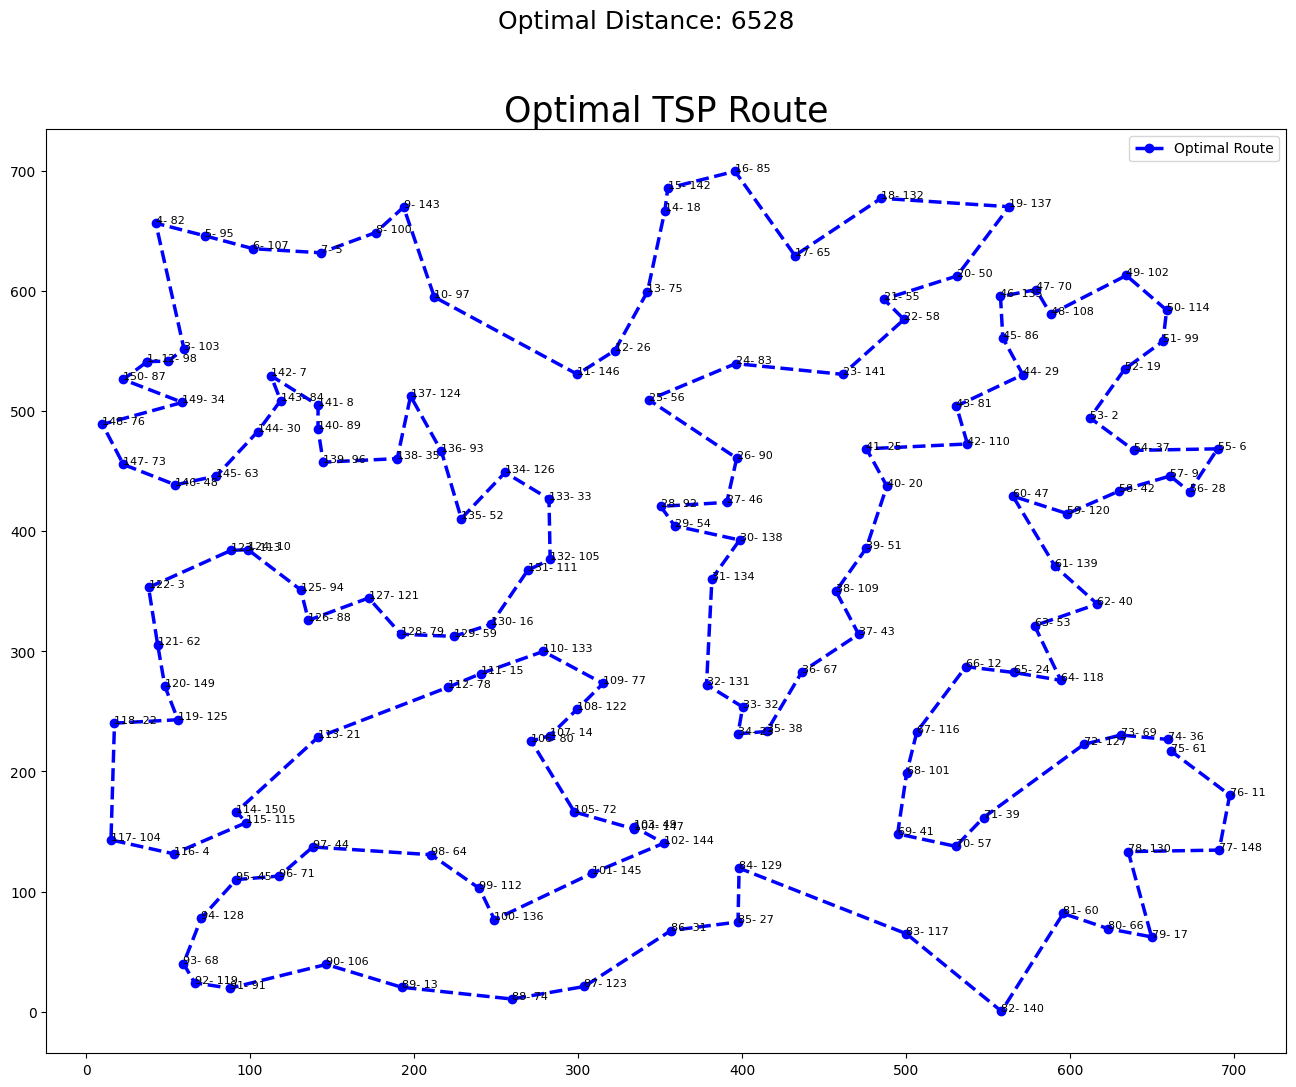

In [94]:
fig, ax = plt.subplots()

# Dibujar la ruta óptima
ax.plot(x_optimal, y_optimal, '--bo', label='Optimal Route', linewidth=2.5)
plt.legend()

# Título y parámetros del gráfico
plt.title(label="Optimal TSP Route", fontsize=25, color="k")
plt.suptitle("Optimal Distance: 6528", fontsize=18)

# Anotar las ciudades en el gráfico
for i, city in enumerate(optimal_tour):
    ax.annotate(f"{i+1}- {city}", (x_optimal[i], y_optimal[i]), fontsize=8)

# Ajustar el tamaño de la figura y mostrar
fig.set_size_inches(16, 12)
plt.show()